In [213]:
import numpy as np
import pandas as pd
import random
import math
import copy
import string
import nltk
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from wordcloud import WordCloud
random.seed = 456

In [214]:
!pip install wordcloud

In [59]:
def normalize_keywords_list(list_of_keyword_dicts):
    normalized_list = []
    for keyword_dict in list_of_keyword_dicts:
        total_value = sum(keyword_dict.values())
        normalized_keywords = keyword_dict.copy()
        for keyword in normalized_keywords:
            normalized_keywords[keyword] /= total_value
        normalized_list.append(normalized_keywords)
    return normalized_list

In [60]:
def calculate_tfidf(list_of_keyword_dicts):
    idf_values = dict.fromkeys(list_of_keyword_dicts[0].keys(), 0.0)

    for keyword_dict in list_of_keyword_dicts:
        for word, frequency in filter(lambda x: x[1] > 0, keyword_dict.items()):
            idf_values[word] += 1.0

    for word in idf_values:
        if idf_values[word]:
            idf_values[word] = math.log(len(list_of_keyword_dicts) / idf_values[word])

    tfidf_results = []
    for keyword_dict in list_of_keyword_dicts:
        keyword_dict = keyword_dict.copy()
        total_frequency = sum(keyword_dict.values())
        for word, frequency in filter(lambda x: x[1] > 0, keyword_dict.items()):
            keyword_dict[word] *= idf_values[word] / total_frequency
        tfidf_results.append(keyword_dict)
    return tfidf_results

In [61]:
def normalize_tfidf(list_of_keyword_dicts):
    list_of_keyword_dicts = calculate_tfidf(list_of_keyword_dicts)
    keywords = list_of_keyword_dicts[0].keys()
    normalized_list = []

    for index, value_dict in enumerate(list_of_keyword_dicts):
        norm = 0

        for v in value_dict.values():
            norm += v**2

        norm = math.sqrt(norm)

        if norm == 0:
            normalized_list.append(dict(zip(keywords, value_dict.values())))
            continue

        normalized_values = map(lambda x: x / norm, value_dict.values())
        normalized_list.append(dict(zip(keywords, normalized_values)))

    return normalized_list

In [62]:
def generate_word_cloud(word_frequency_dict, title, axis=None):

    wordcloud = WordCloud(background_color="white", height=500, width=1000, random_state=random.seed)
    wordcloud.generate_from_frequencies(word_frequency_dict)

    if axis is not None:
        axis.imshow(wordcloud, interpolation='bilinear')
        axis.set_title(title)
        axis.axis(False)
    else:
        plt.subplots(num=None, figsize=(15, 10), dpi=80)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title)
        plt.axis("off")

In [63]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\linag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\linag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\linag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [64]:
stemmer = SnowballStemmer(language='english')
lemmatizer = nltk.WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))
punctuation = string.punctuation

In [65]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
def preprocess_and_stem_nltk(text):
    tokens = word_tokenize(text.lower())
    return [stemmer.stem(word) for word in tokens if word not in stopwords_set and word not in punctuation]

In [67]:
def preprocess_and_lemmatize_nltk(text):
    tokens = word_tokenize(text.lower())
    return [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords_set and word not in punctuation]

In [68]:
def create_total_bag(results):
    word_frequency_dict = dict()
    for result in results:
        tokens = preprocess_and_lemmatize_nltk(result['abstract'])
        for token in tokens:
            if token not in word_frequency_dict:
                word_frequency_dict[token] = 1
            else:
                word_frequency_dict[token] += 1
    return word_frequency_dict

In [69]:
def update_word_frequency(abstract, word_frequency_dict):
    tokens = preprocess_and_lemmatize_nltk(abstract)
    for token in tokens:
        if token in word_frequency_dict:
            word_frequency_dict[token] += 1
    return word_frequency_dict

In [70]:
def remove_low_frequency_words(word_frequency_dict, threshold=0):
    filtered_dict = dict()
    for word, frequency in word_frequency_dict.items():
        if frequency > threshold:
            filtered_dict[word] = frequency
    return filtered_dict

In [71]:
def generate_list_keywords(word_frequency_dict, articles):
    list_keywords = []
    temp_bag = dict.fromkeys(word_frequency_dict, 0)
    for article in articles:
        list_keywords.append(update_word_frequency(article['abstract'], temp_bag.copy()))
    del temp_bag
    return list_keywords

In [72]:
def extract_list_keywords_weights(list_of_keyword_weights):
    list_keywords_weight_items = []
    for item in list_of_keyword_weights:
        list_keywords_weight_items.append(list(item.values()))
    return list_keywords_weight_items

In [73]:
def binary_precision_positive_class(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=0)

def binary_recall_positive_class(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

def binary_f1_positive_class(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=0)

In [74]:
precision_binary_positive = make_scorer(binary_precision_positive_class, greater_is_better=True)
recall_binary_positive = make_scorer(binary_recall_positive_class, greater_is_better=True)
f1_binary_positive = make_scorer(binary_f1_positive_class, greater_is_better=True)

In [75]:
def evaluate_classifier(model, X_train, y_train, X_test=None, y_test=None):
    cross_validator = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    scoring_metrics = {'accuracy': 'accuracy', 'precision_binary_positive': precision_binary_positive, 'recall_binary_positive': recall_binary_positive, 'f1_binary_positive': f1_binary_positive}
    scores = cross_validate(model, X_train, y_train, cv=cross_validator, return_estimator=True, scoring=scoring_metrics)
    return cross_validator, scores

In [76]:
def plot_classifier_roc(list_of_cross_validators, list_of_scores, x_train, y_train, x_test=None, y_test=None):

    list_num_best_models = []
    for i in range(len(list_of_scores)):
        list_num_best_models.append(list_of_scores[i]['test_f1_binary_positive'].argmax())

    best_models = []
    for i in range(len(list_of_scores)):
        best_models.append(list_of_scores[i]['estimator'][list_num_best_models[i]])

    list_x_test = []
    list_y_test = []
    for j in range(len(list_num_best_models)):
        if x_test is None and y_test is None:
            _, test_num = list(list_of_cross_validators[j].split(x_train, y_train))[list_num_best_models[j]]
            x_test, y_test = [], []
            for i in test_num:
                x_test.append(x_train[i])
                y_test.append(y_train[i])
            list_x_test.append(x_test)
            list_y_test.append(y_test)
            x_test = None
            y_test = None

    list_y_proba = []
    for i in range(len(best_models)):
        list_y_proba.append(best_models[i].predict_proba(list_x_test[i])[:, 1])

    list_fpr = [0] * len(list_y_proba)
    list_tpr = [0] * len(list_y_proba)
    for i in range(len(list_y_proba)):
        list_fpr[i], list_tpr[i], _ = roc_curve(list_y_test[i], list_y_proba[i])

    plt.figure(figsize=(15, 10))
    lw = 2
    for i in range(len(list_tpr)):
        plt.plot(
            list_fpr[i],
            list_tpr[i],
            lw=lw,
            label=f'{str(best_models[i]).split("(")[0]}\nAUC = {round(roc_auc_score(list_y_test[i], list_y_proba[i]), 5)}'
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [132]:
def merge_json_files(file_paths: list, output_file_path: str):
    merged_data = []

    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            merged_data.extend(data if isinstance(data, list) else [data])

    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        json.dump(merged_data, output_file, indent=4)

In [153]:
with open('tmccmldm_category.json', 'r', encoding='utf-8') as json_file:
    data_category0 = json.load(json_file)
data_category0

[{'title': 'Text mining for incoming tasks based on the urgency/importance factors and task classification using machine learning tools',
  'authors': "['Yasser Ali Alshehri']",
  'date': 'March 2020',
  'source': "ICCDA '20: Proceedings of the 2020 4th International Conference on Compute and Data Analysis",
  'abstract': 'In workplaces, there is a massive amount of unstructured data from different sources. In this paper, we present a case study that explains how can through communications between employees, we can help to prioritize tasks requests to increase the efficiency of their works for both technical and non-technical workers. This involves managing daily incoming tasks based on their level of urgency and importance.To allow all workers to utilize the urgency-importance matrix as a time-management tool, we need to automate this tool. The textual content of incoming tasks are analyzed, and metrics related to urgency and importance are extracted. A third factor (i.e., the respons

In [154]:
df_category = pd.DataFrame(data_category0)

In [155]:
sum(df_category.link.value_counts() == 2)

22

In [156]:
data[0]

{'title': 'Text mining for incoming tasks based on the urgency/importance factors and task classification using machine learning tools',
 'authors': "['Yasser Ali Alshehri']",
 'date': 'March 2020',
 'source': "ICCDA '20: Proceedings of the 2020 4th International Conference on Compute and Data Analysis",
 'abstract': 'In workplaces, there is a massive amount of unstructured data from different sources. In this paper, we present a case study that explains how can through communications between employees, we can help to prioritize tasks requests to increase the efficiency of their works for both technical and non-technical workers. This involves managing daily incoming tasks based on their level of urgency and importance.To allow all workers to utilize the urgency-importance matrix as a time-management tool, we need to automate this tool. The textual content of incoming tasks are analyzed, and metrics related to urgency and importance are extracted. A third factor (i.e., the response var

In [157]:
len(data)

999

In [158]:
data_category = []
unique_links = set()
TARGET_COUNT = 977

while len(data_category) < TARGET_COUNT:
    random_item = random.choice(data_category0)
    link = random_item['link']

    if link not in unique_links and random_item['abstract']:
        unique_links.add(link)
        data_category.append(random_item)

In [159]:
len(data_category)

977

In [160]:
merge_json_files(['ha_category.json', 'fl_category.json', 'se_category.json', 'sc_category.json', 'cs_category.json', 'db_category.json'], 'not_tmccmldm_categories.json')

In [161]:
with open('not_tmccmldm_categories.json', 'r', encoding='utf-8') as json_file:
    data_no_category0 = json.load(json_file)
data_no_category0

[{'title': 'Reinhardt: Real-time Reconfigurable Hardware Architecture for Regular Expression Matching in DPI',
  'authors': "['Taejune Park', 'Jaehyun Nam', 'Seung Ho Na', 'Jaewoong Chung', 'Seungwon Shin']",
  'date': 'December 2021',
  'source': "ACSAC '21: Proceedings of the 37th Annual Computer Security Applications Conference",
  'abstract': 'Regular expression (regex) matching is an integral part of deep packet inspection (DPI) but a major bottleneck due to its low performance. For regex matching (REM) acceleration, FPGA-based studies have emerged and exploited parallelism by matching multiple regex patterns concurrently. However, even though guaranteeing high-performance, existing FPGA-based regex solutions do not still support dynamic updates in run time. Hence, it was inappropriate as a DPI function due to frequently altered malicious signatures. In this work, we introduce Reinhardt, a real-time reconfigurable hardware architecture for REM. Reinhardt represents regex patterns 

In [162]:
len(data_no_category0)

5709

In [163]:
df_no_category = pd.DataFrame(data_no_category0)

In [164]:
sum(df_no_category.link.value_counts() == 2)

586

In [165]:
data_no_category = []
unique_links_1 = set()
TARGET_COUNT = 4987

while len(data_no_category) < TARGET_COUNT:
    random_item = random.choice(data_no_category0)
    link = random_item['link']

    if link not in unique_links_1 and link not in unique_links and random_item['abstract']:
        unique_links_1.add(link)
        data_no_category.append(random_item)

In [166]:
len(data_no_category)

4987

In [167]:
pd.DataFrame(data_no_category).category.value_counts()/len(data_no_category)

category
Databases                    0.185282
Software AND Engineering     0.176459
Hardware AND Architecture    0.174654
Systems AND Control          0.173852
Computer AND Security        0.167836
Fuzzy AND Logic              0.121917
Name: count, dtype: float64

In [168]:
with open('category.json', 'w') as json_file:
    json.dump(data_category, json_file, indent=4)

In [169]:
with open('no_category.json', 'w') as json_file:
    json.dump(data_no_category, json_file, indent=4)

In [170]:
with open('category.json', 'r') as json_file:
    data_category = json.load(json_file)

In [171]:
with open('no_category.json', 'r') as json_file:
    data_no_category = json.load(json_file)

In [172]:
data_category[0]

{'title': "Application Data Mining Technology in Monitoring Strategies of College Students' English Learning Motivation",
 'authors': "['Shuang Liu']",
 'date': 'September 2021',
 'source': 'ICISCAE 2021: 2021 4th International Conference on Information Systems and Computer Aided Education',
 'abstract': "With the advent of the era of big data, how to apply big data technology to English learning has become a problem that people care about. This research mainly discusses the monitoring strategies of college students' English learning motivation based on data mining. After the collection of Web logs, an information matrix of online learning motivation is formed. Frequent user groups are retrieved through frequently visited page sets, and similar user groups are obtained through association rule analysis, and then related page sets are obtained from frequently visited page sets according to the set distance threshold between pages. Finally, perform cluster analysis on user information to

In [173]:
data_no_category[0]

{'title': 'Tangled: A Conventional Processor Integrating A Quantum-Inspired Coprocessor',
 'authors': "['Henry Dietz']",
 'date': 'August 2021',
 'source': "ICPP Workshops '21: 50th International Conference on Parallel Processing Workshop",
 'abstract': 'Quantum computers use quantum physics phenomena to create specialized hardware that can efficiently execute algorithms operating on entangled superposed data. That hardware must be attached to and controlled by a conventional host computer. However, it can be argued that the main benefit thus far has been from reformulating problems to make use of entangled superpositions rather than from use of exotic physics mechanisms to perform the computation – such reformulations often have produced more efficient algorithms for conventional computers. Parallel bit pattern computing does not simulate quantum computing, but provides a way to use non-quantum, bit-level, massively-parallel, SIMD hardware to efficiently execute a broad class of algor

In [174]:
len(data_category)

977

In [175]:
len(data_no_category)

4987

In [149]:
all_data = data_category + data_no_category

In [176]:
df_category = pd.DataFrame(data_category)

In [184]:
sum(df_category.link.value_counts() == 1)

977

In [177]:
df_no_category = pd.DataFrame(data_no_category)

In [188]:
sum(df_no_category.link.value_counts() == 1)

4987

In [180]:
df = pd.DataFrame(all_data)

In [190]:
sum(df.link.value_counts() == 1)

5274

In [202]:
bag_words_category = create_total_bag(data_category)
bag_words_no_category = create_total_bag(data_no_category)
bag_words = create_total_bag(all_data)

In [204]:
series_bw_category = pd.Series(bag_words_category, index=bag_words_category.keys())
series_bw_no_category = pd.Series(bag_words_no_category, index=bag_words_no_category.keys())
series_bw = pd.Series(bag_words, index=bag_words.keys())

In [206]:
len(series_bw_category)

10129

In [207]:
len(series_bw_no_category)

32171

In [210]:
len(series_bw)

35164

In [211]:
series_bw.sort_values(ascending=False)/len(series_bw)

data         0.227591
system       0.218206
model        0.142617
paper        0.101979
result       0.100415
               ...   
adopter      0.000028
3.1k         0.000028
sewer        0.000028
municipal    0.000028
bcra         0.000028
Length: 35164, dtype: float64

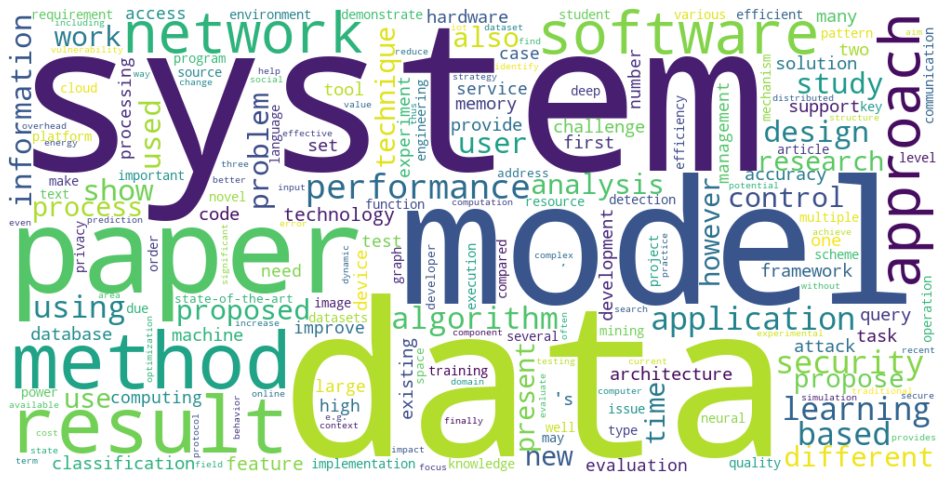

In [216]:
generate_word_cloud(bag_words_category, '')

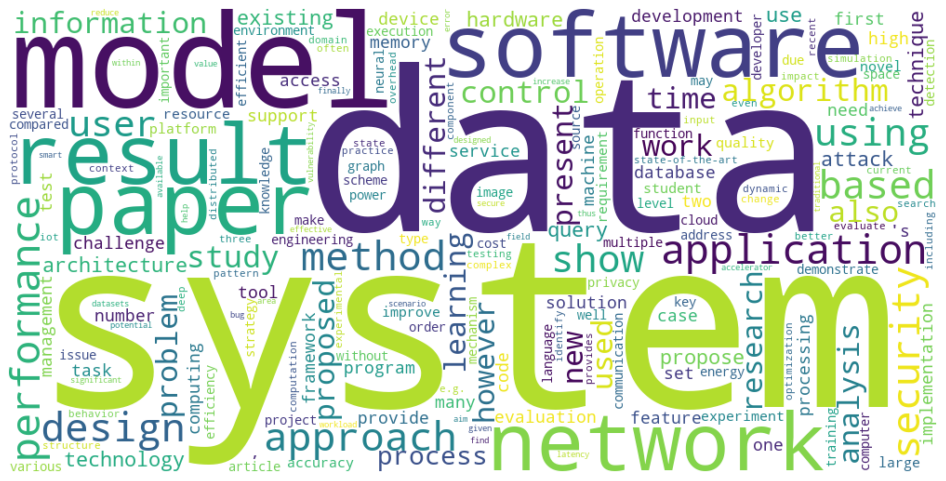

In [217]:
generate_word_cloud(bag_words_no_category, '')

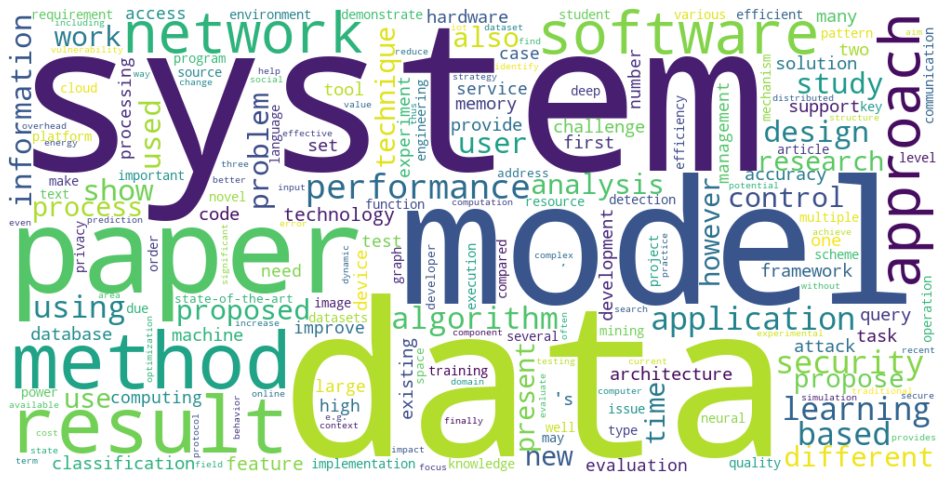

In [218]:
generate_word_cloud(bag_words, '')

In [230]:
bag_words = remove_low_frequency_words(bag_words, threshold=1)

In [231]:
keywords = generate_list_keywords(bag_words, all_data)

In [232]:
keyword_weights = normalize_tfidf(keywords)

In [233]:
arr_keyword_weight_items = np.array(extract_list_keywords_weights(keyword_weights))

In [234]:
pca2 = PCA(n_components=2)

In [235]:
pca2_k = pca2.fit_transform(arr_keyword_weight_items)

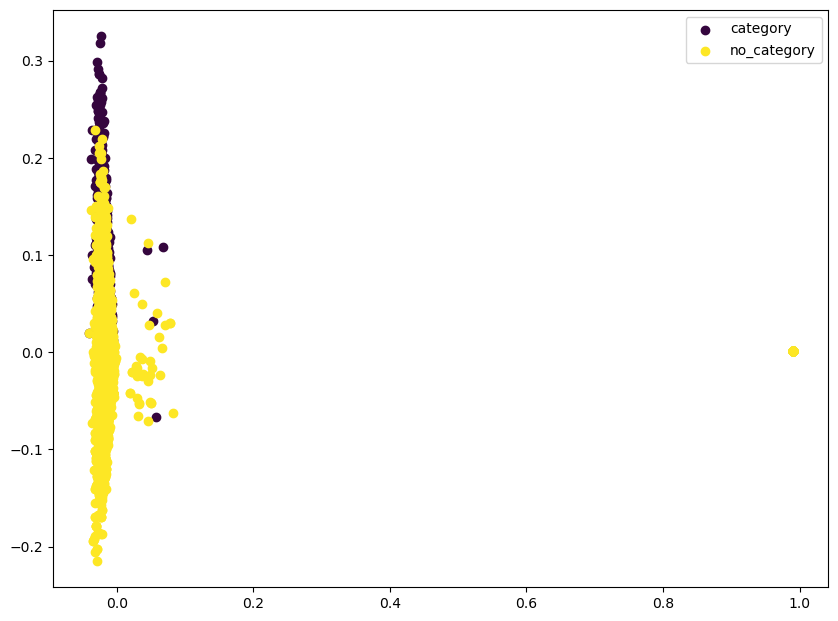

In [236]:
fig = plt.figure(figsize=(10,7.5))
plt.scatter(pca2_k[:977,0],pca2_k[:977,1],label='category',c='xkcd:dark purple')
plt.scatter(pca2_k[977:,0],pca2_k[977:,1],label='no_category',c='#fde725')
plt.legend()
plt.show()